$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Assignment 3: Neural Network Regression

*Type your name here and rewrite all of the following sections.  Add more sections to present your code, results, and discussions.*

## Overview

This assignment will ompare linear and neural network models. Because I like to have a flow, I am continuing with the same Abalone data set I have been working with from the start of the semester. I believe that I will see interesting results since we are now working with a non-linear model; I hope to see a significant improvement in model accuracy with the neural network.  

### Review: Linear Ridge Regression
For the linear model, we will use the same linear method developed in A2: a linear ridge regression. This is an extension of linear regression but we add a second parameter to the optimization function. Instead of simply minimizing the RMSE with a set of weights on the input data, we add a second parameter which amplifies the cost of the weights relative to the bias: $$ \sum_{i=1}^N (\tv_i - \xv_i^T \wv)^2 + \lambda \sum_{i=2}^N w_i^2$$

Here increasing $\lambda$ increases the cost of having large weights. In this way a large $\lambda$ encourages a "flatter" model, closer to a simple average than a linear fit. 

### New model: Neural Networks (<strike>faster</strike>, stronger, better)
A neural network consists of one or more hidden layers and an output layer. It produces a nonlinear model by repreatedly training on an input and re-adjusting its weights to attempt to minimize the output error.

Each layer consists of "units". Each unit contains a weight applied to each input, and the output of a unit is a weighted sum of the inputs which is applied to a "well behaved" function with an easy derivative. One common choice is an assymetric <i>sigmoid</i> function, $h(x) = \frac{1}{1+e^{-a}}$. This function is significant because the derivative is large near 0 and small (asymptotically approaching -1 or 1) farther from zero. 

The output of this function becomes the input of the next layer. For the final layer, there is no application of the sigmoid, just the sum of its inputs. If the error has not converged to an acceptable value and the iteration limit has not been reached, the cycle is iterated by "back propagating" the error through its layers.

## Required Code

In [1]:
# Initial Setup
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import neuralnetworks as nn
np.set_printoptions(suppress=True)
%matplotlib inline
%precision 4

'%.4f'

In [35]:
# train a linear model
def trainLinear(X,T,parameters):
    lamb = parameters
    means = X.mean(0)
    stds = X.std(0)
    n,d = X.shape
    Xs1 = np.insert( (X - means)/stds, 0, 1, axis=1)
    lambDiag = np.eye(d+1) * lamb
    lambDiag[0,0] = 0
    w = np.linalg.lstsq( Xs1.T @ Xs1 + lambDiag, Xs1.T @ T)[0]
    return {'w': w, 'means':means, 'stds':stds}

In [36]:
# use model on X and find RMSE of prediction against T
def evaluateLinear(model,X,T):
    Xs = (X - model['means']) / model['stds']
    Xs1 = np.hstack((np.ones((Xs.shape[0],1)), Xs))
    P = Xs1 @ model['w']
    return np.sqrt( np.mean( (P-T)**2 ) )

In [37]:
def trainNN(X,T,parameters):
    nhs = parameters[0] 
    numInputs = X.shape[1]
    numOutputs = T.shape[1]
    iters = parameters[1] # number of iterations
    net = nn.NeuralNetwork( numInputs, nhs, numOutputs)
    net.train(X,T, nIterations=iters, verbose=False)
    return net

In [38]:
def evaluateNN(model,X,T):
    P = model.use(X)
    return np.sqrt(np.mean((P-T)**2))

I don't like my functions to be longer than a page, or about 50 lines. So I've pulled some functionality out of trainValidateTestKFolds and made them into helper functions.

##### getXTSubset()
Given a set of folds or an integer fold number, returns a subset of X and T matrices corresponding to the rows indicated by the supplied folds.

In [39]:
def getXTSubset(X, T, startsStops, rowIndices, foldParam):
    # do this if foldParam is a fold index
    try: 
        start, stop = startsStops[foldParam]
        rows = rowIndices[start:stop].tolist()
        return (X[rows,:], T[rows,:]) 
    # do this if foldParam is a list of fold indices
    except: 
        rows = []
        for fold in foldParam:
            start, stop = startsStops[fold]
            rows += rowIndices[start:stop].tolist() # this was just = intead of +=
        return (X[rows,:], T[rows,:])

##### updateBestResult()
Comparator for finding best mean error and parameter given current best and new results.

In [40]:
def updateBestResult(bestResult, currentErr, currentParam):
    if bestResult['param'] == None:
        bestResult['param'] = currentParam
        bestResult['meanErr'] = currentErr
    else:
        if bestResult['meanErr'] > currentErr:
            bestResult['meanErr'] = currentErr
            bestResult['param'] = currentParam
    return bestResult

##### calculateStartsStops()
This is the larger portion of the "preparation" section provided us, pulled out to make it clearer what trainValidateTestKFolds is doing and to remove the "block of code" feel.

In [41]:
def calculateStartsStops(nFolds, nSamples):
    '''
    Calculate the starting and stopping row index for each fold.
    return a list of (start,stop) pairs
    '''
    # Calculate number of samples in each of the nFolds folds
    nEach = int(nSamples / nFolds)
    if nEach == 0:
        raise ValueError("partitionKFolds: Number of samples in each fold is 0.")
        
    starts = np.arange(0,nEach*nFolds,nEach)
    stops = starts + nEach
    stops[-1] = nSamples
    return list(zip(starts,stops))

##### trainValidateTestKFolds()
The primary function. This function takes a train and evaluate function from above and uses them to develop models. It returns a list of best parameters achieved for each test fold chosen, as well as the best errors for the validate, train, and test subsets for that set of parameters.

In [42]:
def trainValidateTestKFolds(trainf,evaluatef,X,T,parameterSets,nFolds,
                            shuffle=False,verbose=False):
    # Randomly arrange row indices
    rowIndices = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(rowIndices)
   
    # get list of starts/stops
    startsStops = calculateStartsStops(nFolds, X.shape[0])
    results = []

    folds = range(nFolds)
    for testFold in folds: # For each test fold
        bestResult = {'param': None, 'meanErr': None }
        for parmSet in parameterSets:  # For each set of parameter values, called parmSet
            # Find best set of parameter values
            errs = []
            for validateFold in folds:  # For each validate fold (except when same as test fold)
                if testFold != validateFold:
                    # get subsets
                    trainFolds = np.setdiff1d(folds, [testFold,validateFold])  # get list of folds for train set
                    Xtest, Ttest = getXTSubset(X, T, startsStops, rowIndices, testFold)
                    Xtrain, Ttrain = getXTSubset(X, T, startsStops, rowIndices, trainFolds) # get train subset
                    Xval, Tval = getXTSubset(X, T, startsStops, rowIndices, validateFold) # get validate subset
                    model = trainf(Xtrain, Ttrain, parmSet)  # Use trainf to fit model to training data using parmSet
                    errs.append(evaluatef(model, Xval, Tval))  #get the error for this set and model
            meanErr = np.mean(errs) # Calculate the mean of these errors.
            bestResult = updateBestResult(bestResult, meanErr, parmSet) # update  the best result for this test  
        
        # Make a new set of training data by concatenating train and val sets
        Xtrain = np.vstack((Xtrain, Xval))
        Ttrain = np.vstack((Ttrain, Tval))
        # Retrain, using trainf again, to fit a new model using the best set of parameter values
        #  found above, to this new training data.
        bestModel = trainf(Xtrain, Ttrain, bestResult['param'])
        # Calculate error on test and train
        trainErr = evaluatef(bestModel, Xtrain, Ttrain)
        testErr = evaluatef(bestModel, Xtest, Ttest)
        #construct result for this test fold
        result = [ bestResult['param'], trainErr, bestResult['meanErr'], testErr ]        
        # Print this list if verbose == True
        if verbose:
            print(result)
        # Append this list to a result list
        results.append(result)
    # Return this result list
    return results

## Data
I have chosen to continue with the abalone data I have been working with, prepared in the same way as in the past assignments. My goal is to see how different methods of modeling the data affect my errror. I expect (or at least hope) that i am able to get an improved fit with the neural network. To refresh, data for abalone is described in the table below:

### Source

The data chosen is Abalone Data from the <a href="http://archive.ics.uci.edu/ml/datasets/Abalone">UC Irvine Machine Learning Repository</a>. The data set originated from a prior study by Nash et. al[1].

<table>
<tr><th>Name</th> <th>Data Type</th> <th>Meas.</th> <th>Description</th></tr>
<tr><td>Sex				</td><td>nominal	</td><td>		</td><td>M, F, and I (infant)</td></tr>
<tr><td>Length			</td><td>continuous	</td><td>mm		</td><td>Longest shell measurement</td></tr>
<tr><td>Diameter		</td><td>continuous	</td><td>mm		</td><td>perpendicular to length</td></tr>
<tr><td>Height			</td><td>continuous	</td><td>mm		</td><td>with meat in shell</td></tr>
<tr><td>Whole weight	</td><td>continuous	</td><td>grams	</td><td>whole abalone</td></tr>
<tr><td>Shucked weight	</td><td>continuous	</td><td>grams	</td><td>weight of meat</td></tr>
<tr><td>Viscera weight	</td><td>continuous	</td><td>grams	</td><td>gut weight (after bleeding)</td></tr>
<tr><td>Shell weight	</td><td>continuous	</td><td>grams	</td><td>after being dried</td></tr>
<tr><td>Rings			</td><td>integer	</td><td>		</td><td>+1.5 gives the age in years</td></tr>
</table>

Here we parse the file and examine the inputs. To see if we can get more insight into the data compared to A1 and A2's analysis, we will generate some histograms for the data: Three sets of histograms, one per gender, each with an age and a weight histogram. I expect to see curves fitting a normal distribution for each gender, with males being generally heavier and infants being much lighter. I believe females will have a bias toward older abalone and infants will (naturally) be younger.

In [43]:
# function for creating an integer from gender column
def genderCheck(gender):
    if ord(gender) == ord('M'):
        return 1
    if ord(gender) == ord('F'):
        return 2
    if ord(gender) == ord('I'):
        return 3
    return 0

# retrieve data from text
rawData = np.loadtxt('abalone.data',delimiter=',', usecols=(0,4,5,6,7,8), converters={0: genderCheck})

# parse gender into three arrays of binary values
mMask = (rawData[:,0] == 1).reshape(-1,1)
fMask = (rawData[:,0] == 2).reshape(-1,1)
iMask = (rawData[:,0] == 3).reshape(-1,1)

# concatenate arrays with the the input data sliced to remove gender
splitGenders = np.hstack((mMask, fMask, iMask, rawData[:,1:]))

# add 1.5 to the rings column to get ages
splitGenders[:,7] += 1.5

ages = splitGenders[:,7]
wholeWeights = splitGenders[:,3:4]

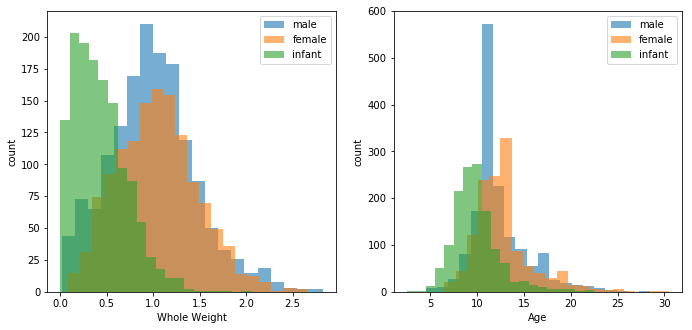

In [44]:
mWhole = wholeWeights[splitGenders[:,0] == 1]
fWhole = wholeWeights[splitGenders[:,1] == 1]
iWhole = wholeWeights[splitGenders[:,2] == 1]
mAges = ages[splitGenders[:,0] == 1]
fAges = ages[splitGenders[:,1] == 1]
iAges = ages[splitGenders[:,2] == 1]
names = ['whole weight', 'schucked weight', 'viscera weight', 'shell weight']  

mWhole.shape

plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
plt.hist(mWhole, histtype='bar', alpha=0.60, bins=20, label='male')
plt.hist(fWhole, histtype='bar', alpha=0.60, bins=20, label='female')
plt.hist(iWhole, histtype='bar', alpha=0.60, bins=20, label='infant')
plt.xlabel('Whole Weight')
plt.ylabel('count')
plt.legend(loc='upper right')
plt.subplot(5,5,2)
plt.hist(mAges, bins=20, histtype='bar', alpha=0.60, label='male')
plt.hist(fAges, bins=20, histtype='bar', alpha=0.60, label='female')
plt.hist(iAges, bins=20, histtype='bar', alpha=0.60, label='infant')
plt.xlabel('Age')
plt.ylabel('count')
plt.legend(loc='upper right')
plt.show()

Data follows trends as expected. A few curious points. For all three sets, though particularly infants, weights were skewed toward the lighter side, indicating that for this data at least, there are more unusually light abalone than unusually heavy. Age is also interesting. Apparently there were very few abalone in the younger bins (less than 5). The curve is definintely normal, but heavily skewed. I would interpret this as a tendency toward the younger average. The majority of abalone will fall near the mean age, with relatively fewer particularly old abalone, but there are almost none at all under 5 years. This could be due to harvesting regulations (perhaps abalone must be thrown back below a certain number of rings?) Or that there is simply a natural bias toward not reaching older ages. This does confirm my expectation that the data should fit a gaussian curve; hopefully this fit is realized by the neural net.

## Results



We begin by forming models for comparison. Recall my goal is to show that a nonlinear curve will be a better fit for the abalone data than a linear fit, so we will do a linear regression to provide a linear model and we will use a neural network to give us a nonlinear model.

### Developing the Linear Model
First we need a linear model. 

### Developing the Neural Network Model
Next we develop a model using a neural network. The network consists of a series of layers, each layer's outputs are inputs to the next layer's units until finally reaching the output layer.

### Comparison of model accuracy

Investigate the use of a linear model with various $\lambda$ values for your chosen data.  Then investigate the use of a neural network model on the same data for various sizes of hidden layers and numbers of iterations.
Discuss the results obtained, including the error values and the parameter values that result in the best performance.

Apply the `trainValidateTestKFolds` function, print the results, and discuss them.  How much variation is there in the best parameter values across different test folds?  Does the complexity of the models, in terms of the best parameters found, make sense?

## Grading

Your notebook will be run and graded automatically. Download [A3grader.tar](http://www.cs.colostate.edu/~anderson/cs480/notebooks/A3grader.tar) and extract `A3grader.py` from it. Run the code in the following cell to demonstrate an example grading session.  You should see a perfect score of 80/100 if your functions are defined correctly.  The remaining 20% will be based on the instructors reading of your notebooks.  We will be looking for how well the method is explained in text with some LaTeX math, and how well the results are summarized.

In [12]:
%run -i "A3grader.py"

 Testing: result = trainValidateTestKFolds(trainLinear,evaluateLinear,X,T,
                  range(0,101,10),nFolds=5,shuffle=False)
 Your result is
    10   3.158   4.132   2.414
    20   4.368   5.021   3.641
    10   3.245   4.178   5.03
    20   4.448   6.07   2.024
    20   2.426   2.972   10.89
20/20 points. First column, of best lambda values, is correct.
20/20 points. Columns of RMSE values are correct.

 Testing:
   import itertools
   parms = list(itertools.product([[5],[5,5],[2,2,2]], [10,50,100,200]))
   te = []
   for rep in range(5):
       result = trainValidateTestKFolds(trainNN,evaluateNN,X,T,
                                        parms,
                                        nFolds=4,shuffle=False)
       resulte = np.array([r[1:] for r in result])
       meanTestRMSE = resulte[:,-1].mean()
       print('     ',meanTestRMSE)
       te.append(meanTestRMSE)
      2.36655668628
      2.13289773041
      1.45450525073
      2.11981125872
      1.31169974584
40/40 point

## Check-in